In [2]:
!pip install editdistance
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q
!pip install editdistance

import locale
import pandas as pd
import numpy as np
import re
import sys
import typing as tp
import unicodedata
import gc
import random
import torch
import sacrebleu
import editdistance
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig, get_constant_schedule_with_warmup
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from sacremoses import MosesPunctNormalizer


pd.options.display.max_colwidth = 100


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 38.0 MB/s eta 0:00:00


In [5]:
trans_df = pd.read_csv('trans_df.csv')

print(trans_df.shape)
print(trans_df.columns)

(118182, 4)
Index(['Unnamed: 0', 'ru', 'tyv', 'split'], dtype='object')


In [6]:
trans_df.sample(10)

,Unnamed: 0,ru,tyv,split
85636,85642,"Зверей он убивал очень милосердно, просто ударял их хвостом, так что они даже не успевали ничего...","Аңнарга ол аажок хайыралыг бооп, олар чүнү-даа эскерип четтикпээнде, анаа-ла кудуруу-биле өлүр с...",train
108680,108689,исход сражения,тулчуушкуннуң түңнели,train
27358,27361,негативные стороны,четпес талалары,train
115259,115268,нестись,кончуг дүрген маңнаар,train
27845,27848,разуть,идиин уштур,train
91437,91444,меченые атомы,демдектиг атомнар,train
35958,35961,чванство,адыыргак чорук,train
44287,44290,молоток,маска,train
48879,48883,"Стоит, конечно, если они поймут.","Бир эвес билип аптарлар болза, херээ бар болбайн канчаар.",train
101575,101584,затихнуть,даажы чидер,train


In [7]:
trans_df = trans_df[trans_df.ru.notna()]
trans_df.isnull().sum()

Unnamed: 0    0
ru            0
tyv           0
split         0
dtype: int64

In [8]:
trans_df.split.value_counts()

split
train    108183
test       5000
dev        4999
Name: count, dtype: int64

In [9]:
df_train = trans_df[trans_df.split=='train'].copy()
df_dev = trans_df[trans_df.split=='dev'].copy()
df_test = trans_df[trans_df.split=='test'].copy()

In [10]:
from transformers import MBart50Tokenizer, MBartForConditionalGeneration

tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional 

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

In [11]:
def word_tokenize(text):
    return re.findall('(\w+|[^\w\s])', text)

In [12]:
smpl = df_train.sample(10000, random_state=1)

smpl['rus_toks'] = smpl.ru.apply(tokenizer.tokenize)
smpl['tyv_toks'] = smpl.tyv.apply(tokenizer.tokenize)

smpl['rus_words'] = smpl.ru.apply(word_tokenize)
smpl['tyv_words'] = smpl.tyv.apply(word_tokenize)

In [13]:
smpl.sample(5)[['tyv', 'tyv_words', 'tyv_toks', 'ru', 'rus_words', 'rus_toks']]

,tyv,tyv_words,tyv_toks,ru,rus_words,rus_toks
106000,"Сүлде-сүзүк практиказы даштыкы чүвелер – аъш-чем, идик-хеп болгаш өске-даа ындыг янзылыгларынга ...","[Сүлде, -, сүзүк, практиказы, даштыкы, чүвелер, –, аъш, -, чем, ,, идик, -, хеп, болгаш, өске, -...","[▁С, үл, де, -, сүз, үк, ▁практика, зы, ▁да, шты, кы, ▁, чү, ве, лер, ▁–, ▁а, ъ, ш, -, чем, ,, ▁...","Духовная практика не касается внешних вещей – пищи, одежды и тому подобного.","[Духовная, практика, не, касается, внешних, вещей, –, пищи, ,, одежды, и, тому, подобного, .]","[▁Духов, ная, ▁практика, ▁не, ▁касается, ▁внешних, ▁вещей, ▁–, ▁пи, щи, ,, ▁одежды, ▁и, ▁тому, ▁..."
57249,чай дургузунда уругларның кадыы быжыга берген,"[чай, дургузунда, уругларның, кадыы, быжыга, берген]","[▁чай, ▁дур, гуз, унда, ▁у, руг, лар, ның, ▁кад, ы, ы, ▁бы, жы, га, ▁берген]",ребята за лето окрепли,"[ребята, за, лето, окрепли]","[▁ребята, ▁за, ▁лето, ▁окре, пли]"
43316,эрге-хоойлу системазы,"[эрге, -, хоойлу, системазы]","[▁эр, ге, -, хо, ой, лу, ▁система, зы]",система права,"[система, права]","[▁система, ▁права]"
58149,үстүрер,[үстүрер],"[▁үс, түр, ер]",удариться,[удариться],"[▁удари, ться]"
25906,епископ кафедра,"[епископ, кафедра]","[▁епископ, ▁кафедр, а]",епископская кафедра,"[епископская, кафедра]","[▁епископ, ская, ▁кафедр, а]"


In [14]:
stats = smpl[['rus_toks', 'tyv_toks', 'rus_words', 'tyv_words']].applymap(len).describe()
stats

,rus_toks,tyv_toks,rus_words,tyv_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.967800,12.576300,4.833600,5.382500
std,9.582805,16.402057,6.508544,7.216564
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,4.000000,1.000000,1.000000
50%,5.000000,7.000000,2.000000,3.000000
75%,8.000000,13.000000,5.000000,6.000000
max,97.000000,186.000000,73.000000,76.000000


In [15]:
print(stats.rus_toks['mean'] / stats.rus_words['mean'])
print(stats.tyv_toks['mean'] / stats.tyv_words['mean'])

1.6484193975504802
2.3365164886205294


In [16]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


In [17]:
texts_with_unk = [text for text in tqdm(trans_df.tyv) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/118182 [00:00<?, ?it/s]

0


In [ ]:
import random
s = random.sample(texts_with_unk, 5)
s

In [18]:
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [19]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

0it [00:00, ?it/s]

0


In [20]:
print(tokenizer)
print(len(tokenizer))

MBart50Tokenizer(name_or_path='facebook/mbart-large-50-many-to-many-mmt', vocab_size=250054, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN', 'af_ZA', 'az_AZ', 'bn_IN', 'fa_IR', 'he_IL', 'hr_HR', 'id_ID', 'ka_GE', 'km_KH', 'mk_MK', 'ml_IN', 'mn_MN', 'mr_IN', 'pl_PL', 'ps_AF', 'pt_XX', 'sv_SE', 'sw_KE', 'ta_IN', 'te_IN', 'th_TH', 'tl_XX', 'uk_UA', 'ur_PK', 'xh_ZA', 'gl_ES', 'sl_SI']}, clean_up_tokenization_spaces=True)
250054


In [21]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [22]:
fix_tokenizer(tokenizer)

In [24]:
#print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

[3, 250053, 250054]


In [25]:
added_token_id = tokenizer.convert_tokens_to_ids('tyv_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

250053 3


In [26]:
from transformers import MBartForConditionalGeneration
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
model.resize_token_embeddings(len(tokenizer))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 250055. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(250055, 1024)

In [27]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

In [28]:
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [29]:
model.cuda();

In [30]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [31]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [32]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [33]:
LANGS = [('ru', 'ru_RU'), ('tyv', 'tyv_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))
# (['чеди'], ['семь'], 'tyv_Cyrl', 'rus_Cyrl')

(['незабвенный друг'], ['уттундурбас өңнүк'], 'ru_RU', 'tyv_Cyrl')


In [35]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

  0%|          | 0/57000 [00:00<?, ?it/s]

0 8.291547775268555
1000 3.9276481573581696
2000 2.7647558344602583
3000 2.383089956998825
4000 2.16322613799572
5000 2.0106528606414793
6000 1.86951452344656
7000 1.7791471534967422
8000 1.726362785756588
9000 1.6389358420968057
10000 1.5756334022879601
11000 1.5164537788629533
12000 1.4627376015782356
13000 1.4081187140345572
14000 1.3878179827928543
15000 1.3399817328453063
16000 1.3054084593951703
17000 1.2636750347614287
18000 1.2387266886234283
19000 1.2013965864777565
20000 1.1690290038585662
21000 1.1388724241554737
22000 1.1114046586453914
23000 1.0891676680743694
24000 1.063155462116003
25000 1.0431793757081032
26000 1.0140489878356456
27000 1.0173631075918674
28000 0.969324807614088
29000 0.95193790102005
30000 0.9385842967331409
31000 0.9138531367778778
32000 0.8947197423875332
33000 0.8745453424453735
34000 0.8576430125236512
35000 0.8484066400527954
36000 0.8266891530007124
37000 0.8098796525299549
38000 0.7989135776907206
39000 0.7863087584376335
40000 0.7691799373924733

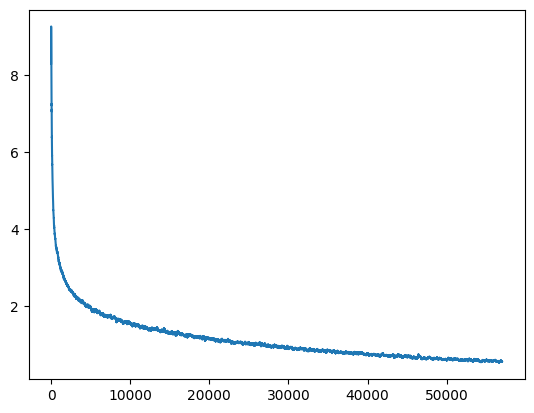

In [37]:
pd.Series(losses).ewm(100).mean().plot();

In [ ]:
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))

        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [44]:
def translate(text, src_lang='ru_RU', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [50]:
df_dev['rus_translated'] = [translate(t, 'tyv_Cyrl', 'ru_RU')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv_translated'] = [translate(t, 'ru_RU', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [51]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [52]:
xx, yy = ['течёт холод'], ['несёт холодом']
print(bleu_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(yy, [xx]))

BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2)
chrF2++ = 36.75
chrF2++ = 42.30


In [53]:
print(bleu_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 16.92 45.7/22.6/12.7/7.5 (BP = 0.954 ratio = 0.955 hyp_len = 22160 ref_len = 23207)
chrF2++ = 40.99
BLEU = 17.52 46.2/23.1/13.2/7.9 (BP = 0.958 ratio = 0.959 hyp_len = 22232 ref_len = 23188)
chrF2++ = 44.67


In [56]:
print((df_dev.ru == df_dev.rus_translated).mean())
print((df_dev.tyv == df_dev.tyv_translated).mean())

0.22804560912182437
0.21804360872174436


In [57]:
def ed_similarity(text1, text2):
    return max(0, 1 - editdistance.eval(text1, text2) / min(len(text1), len(text2)))

print(ed_similarity('кот', 'собака'))
print(ed_similarity('кот', 'кит'))

0
0.6666666666666667


# Publishing the model to HF

In [58]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

In [ ]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [60]:
upload_repo = "Nacoor/mbart-v2"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Nacoor/mbart-v2/commit/10ccd44e0311ede3667f2b82334c49379a9c40ba', commit_message='Upload MBartForConditionalGeneration', commit_description='', oid='10ccd44e0311ede3667f2b82334c49379a9c40ba', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', '<mask>', 'tyv_Cyrl']

[256202, 256204, 256203]


Testing that it works

In [64]:
MODEL_URL = 'Nacoor/mbart-v2'
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL)
tokenizer = MBart50Tokenizer.from_pretrained(MODEL_URL, force_download=True)
fix_tokenizer(tokenizer)

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/896 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [65]:
def translate(
    text,
    model,
    tokenizer,
    src_lang='ru_RU',
    tgt_lang='tyv_Cyrl',
    max_length='auto',
    num_beams=4,
    no_repeat_ngram_size=4,
    n_out=None,
    **kwargs
):
    tokenizer.src_lang = src_lang
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if max_length == 'auto':
        max_length = int(32 + 2.0 * encoded.input_ids.shape[1])
    model.eval()
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
        max_length=max_length,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        num_return_sequences=n_out or 1,
        **kwargs
    )
    out = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    if isinstance(text, str) and n_out is None:
        return out[0]
    return out

In [70]:
translate("я хочу есть", model=model, tokenizer=tokenizer)

'чемнениксеп тур мен'